# HACI-Fälle 2013, NC-Komposit des CI-Zeitpunktes

Für eine subjektive Einteilung der Fälle, ist es notwendig sich die CI-Zeipunkte anzusehen.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import xarray as xr
import glob

from standard_config import *

import sys
sys.path.append("{}/utils".format(local_home_path))
import load_satellite_data as lsd
import fixed_colourbar as fc

from analysis_tools import grid_and_interpolation as gi

import time
from IPython.display import clear_output

from l15_msevi import msevi as msv
import MSGtools as mst

from tqdm import tqdm

In [2]:
# nc_channels = ['VIS006','VIS008','IR_016']
channels = ['VIS006','VIS008','IR_016','IR_039','WV_062','WV_073','IR_087','IR_108','IR_120']

In [3]:
def cutout_box(data, row, col, box_size):
    cutout = gi.cutout_field4box(data,(row,col),box_size)
    
    return cutout

def normalise2range(data,dmin = None, dmax = None, new_min = 0, new_max = 1,gamma=1):
  
    data = data**(1/gamma)
   
    if dmin == None and dmax == None:
        data_std = ((data - np.min(data)) / (np.max(data) - np.min(data)))
    else:
        data_std = ((data - dmin) / (dmax - dmin))
        data_std = ((data - np.min(data)) / (np.max(data) - np.min(data)))

    data_scaled = data_std * (new_max - new_min) + new_min
    
    return data_scaled

def array_to_255(d, gamma = 1.0):

    dat = d.copy()
    # remove outliners for dat>1. or dat<0.
    dat[dat>1.] = 1.
    dat[dat<0.] = 0.

    if not gamma == 1.0:
        dat = dat ** (1./gamma) 
   
    # transform (0,1)-data to (0,255)-image-scale 
    rgb = 255 * dat
   
    return rgb.astype('uint8')

def scale_array_min_max(array_data,range_min=0,range_max=1):
    """
    Scales a array into the chosen range.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
    range_min: int or float, default = 0
        minimum value of the range to scale array to,
    range_max: int or float, default = 1
        maximum value of the range to scale array to,
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """
    # get array extrema
    array_min = np.min(array_data)
    array_max = np.max(array_data)

    # derive conversion parameters
    a = (range_max - range_min) / (array_max - array_min)
    b = range_max - a * array_max

    # scale array
    scaled_array = a * array_data + b
    
    return scaled_array

def add_hrv_texture2nc(nc,hrv):
    nc_lab = color.rgb2lab(nc)
    l_min = nc_lab[...,0].min()
    l_max = nc_lab[...,0].max()
    
    l_hrv_scaled = nc_lab[...,0] * hrv
    l_hrv_scaled = scale_array_min_max(l_hrv_scaled,l_min,l_max)

    nc_lab[...,0] = l_hrv_scaled
    
    return color.lab2rgb(nc_lab)
    
def gamma2(values,gamma):
    vmin = np.min(values)
    vmax = np.max(values)
    
    vmean = (vmin + vmax)/2
    
    below_mean = np.where(values < vmean)
    above_mean = np.where(values >= vmean)
    out = np.zeros(values.shape)
    out[below_mean] = 128 - 128 * ((vmean - values[below_mean]) / (vmean - vmin))**(1/gamma)
    out[above_mean] = 128 + 128 * ((values[above_mean] - vmean) / (vmax - vmean))**(1/gamma)
    
    return out
    
def sat_rgb(red_channel,green_channel,blue_channel):
    red = array_to_255(red_channel,1.0)
    green = array_to_255(green_channel,1.0)
    blue = array_to_255(blue_channel,1.0)
    
    return np.dstack([red,green,blue]).astype("uint8")

def day_natural_composite(vis006_data,vis008_data,nir016_data):
    (rmin, rmax, rgamma) = (0,1,1)
    (gmin, gmax, ggamma) = (0,1,1)
    (bmin, bmax, bgamma) = (0,1,1)
    
    comp = sat_rgb(np.clip(nir016_data,rmin,rmax),
                   np.clip(vis008_data,gmin,gmax),
                   np.clip(vis006_data,bmin,bmax))

    return comp    

def day_microphysics_rgb(vis008_data,ir039_data,ir108_data):
    (rmin, rmax, rgamma) = (0,1,1)
    (gmin, gmax, ggamma) = (0, 0.6, 2.5)
    (bmin, bmax, bgamma) = (203,323,1)
    
    comp = sat_rgb(normalise2range(vis008_data, rmin, rmax, 0,1, rgamma),
                   normalise2range(ir039_data, gmin, gmax, 0,1, ggamma),
                   normalise2range(ir108_data, bmin, bmax, 0,1, bgamma))
    
    return comp

def day_solar_rgb(vis008_data,ir016_data,ir039_data):
    (rmin, rmax, rgamma) = (0,1,1.7)
    (gmin, gmax, ggamma) = (0,0.7,1)   
    (bmin, bmax, bgamma) = (0,0.6,2.5)

    comp = sat_rgb(normalise2range(vis008_data,rmin,rmax,0,1,rgamma),
                   normalise2range(ir016_data,gmin,gmax,0,1,ggamma),
                   normalise2range(ir039_data,bmin,bmax,0,1,bgamma))
    
    return comp

def conv_rgb(vis006_data,ir016_data,ir039_data,wv062_data,wv073_data,ir108_data):
    (rmin, rmax, rgamma) = (-30,0,1)
    (gmin, gmax, ggamma) = (0,55,0.5)   
    (bmin, bmax, bgamma) = (-0.7,0.2,1)
    
    r = normalise2range(wv062_data - wv073_data, rmin, rmax,0,1,rgamma)
    g = normalise2range(ir039_data - ir108_data, gmin, gmax,0,1,ggamma)
    b = normalise2range(ir016_data - vis006_data, bmin, bmax,0,1bgamma)
    
    comp = sat_rgb(r,g,b)
    
    return comp

def night_conv_rgb(ir039_data,ir108_data,ir120_data):
    (rmin, rmax, rgamma) = (-4,2,1)
    (gmin, gmax, ggamma) = (0,6,2)   
    (bmin, bmax, bgamma) = (243,293,1)
    
    r = normalise2range(ir120_data - ir108_data, rmin, rmax, 0, 1, rgamma)
    g = normalise2range(ir108_data - ir039_data, gmin, gmax, 0, 1, ggamma)
    b = normalise2range(ir108_data, bmin, bmax, 0, 1, bgamma)
    
    comp = sat_rgb(r,g,b)
    
    return comp

def determine_IR039_reflectance(day,scan_type='rss'):
    import datetime as dt
    from l15_msevi import msevi as msv
    from l15_msevi.msevi_config import _calibration_constants
    import MSGtools as mst
    
    s = msv.MSevi(day,chan_list=['IR_039','IR_108','IR_134'],scan_type=scan_type)
    s.rad2bt()
    
    # CO2-korrigierte Radianz
    R_corr = (s.bt['IR_108'] - 0.25* (s.bt['IR_108'] - s.bt['IR_134'])**4) / (s.bt['IR_108']**4)
    
    # CO2-korrigierte Helligkeitstemperatur
    bt_039_korr = (s.bt['IR_039']**4 + R_corr)**0.25
    
    # Konstanten
    c1 = 1.19104e-5
    c2 = 1.43877
    nu_c = _calibration_constants[s.sat_type]['nu_c']['IR_039']
    A = _calibration_constants[s.sat_type]['A']['IR_039']
    B = _calibration_constants[s.sat_type]['B']['IR_039']
    
    # Rückumrechnung von BT(10,8) zu L(10,8) mit Konstanten des IR039-Kanals
    R_108 = (c1 * nu_c**3)  / (np.exp((c2*nu_c) / (A*s.bt['IR_108'] + B)) - 1 )
    
    # korrigierte thermische Komponente der Radianz
    R_therm = R_108 * R_corr
    
    # CO2-korrigierte Solarkonstante an der Atmosphärenoberseite
    jday = int(day.strftime('%j'))
    esd = 1. - 0.0167 * np.cos( 2*np.pi*(jday-3.) / 365 )
    
    cos_sun_zenith = mst.get_cos_zen(day,scan_type=scan_type)
    cos_sat_zenith = np.cos(np.deg2rad(mst.get_msg_sat_zen(day,sat_type=scan_type)))
    
    solar_constant = 4.92 / esd**2
    CO2_att_cloud_sat = np.exp(-(1 - s.rad['IR_039']))
    CO2_att_cloud_sun = np.exp(-(1 - s.rad['IR_039']) * (cos_sun_zenith / cos_sat_zenith))
    
    R_toa = solar_constant * cos_sun_zenith * CO2_att_cloud_sat * CO2_att_cloud_sun
    
    # Reflektanz des IR039-Kanals
    ref_039 = ((s.rad['IR_039'] - R_therm) / (R_toa - R_therm))
    
    return bt_039_korr, ref_039

## HACI-Falldaten laden und das Jahr 2013 auswählen

In [6]:
haci_objects = pd.read_csv("{}/HACI_bbox_data/haci-2008-2017-bbox-filtered.csv".format(local_data_path))

In [7]:
year = [int(pd.Timestamp(case.date).strftime("%Y")) for i, case in haci_objects.iterrows()]

In [9]:
haci_objects = haci_objects.assign(year=year)

In [10]:
haci_objects_2013 = haci_objects[haci_objects.year == 2013]

In [11]:
len(haci_objects_2013.index)

1033

Im Ganzen haben wir {{len(haci_objects_2013.index)}} Fälle, die wir uns im Folgenden ansehen. Das sollte ausreichen, um einen repräsentativen Überblick über mögliche Fallklassen zu erhalten.

## Fälle durchlaufen und Ausschnitt des NC-Komposits für den CI-Zeitpunkt erstellen

In [12]:
pic_target = "{}/proj/2019-01_trackingstudie/pics/cutout_t0".format(local_home_path)

In [13]:
plt.switch_backend("Agg")

In [22]:
for i, case in tqdm(haci_objects_2013.iterrows(),total=len(haci_objects_2013.dt.values)):
#for i, case in haci_objects.iterrows():
    try:
        ci_time = pd.Timestamp("{}T{}".format(case.date,case.time)).to_pydatetime()
        case_id = "{}_{}".format(ci_time.strftime("%Y%m%d"),case.id)

        sat_data = lsd.load_satellite_data_multichannel(ci_time,channels)
        cos_sun_zenith = mst.get_cos_zen(ci_time,scan_type='rss')

        nc = day_natural_composite(cutout_box(sat_data['VIS006'],case.msg_eu_l0,case.msg_eu_c0,51),
                                   cutout_box(sat_data['VIS008'],case.msg_eu_l0,case.msg_eu_c0,51),
                                   cutout_box(sat_data['IR_016'],case.msg_eu_l0,case.msg_eu_c0,51))
        
        bt039, ref039 = determine_IR039_reflectance(ci_time)
        mp = day_microphysics_rgb(cutout_box(sat_data['VIS008'],case.msg_eu_l0,case.msg_eu_c0,51),
                                  cutout_box(ref039,case.msg_eu_l0,case.msg_eu_c0,51),
                                  cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51))
    
        cv = conv_rgb(cutout_box(sat_data['VIS006'],case.msg_eu_l0,case.msg_eu_c0,51),
                      cutout_box(sat_data['IR_016'],case.msg_eu_l0,case.msg_eu_c0,51),
                      cutout_box(sat_data['IR_039'],case.msg_eu_l0,case.msg_eu_c0,51),
                      cutout_box(sat_data['WV_062'],case.msg_eu_l0,case.msg_eu_c0,51),
                      cutout_box(sat_data['WV_073'],case.msg_eu_l0,case.msg_eu_c0,51),
                      cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51))
        
        ncv = night_conv_rgb(cutout_box(sat_data['IR_039'],case.msg_eu_l0,case.msg_eu_c0,51),
                             cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51),
                             cutout_box(sat_data['IR_120'],case.msg_eu_l0,case.msg_eu_c0,51))

        #nc_cutouts[case_id] = nc
        fig,ax = plt.subplots(1,4,figsize=(16,4))
        ax[0].imshow(nc)
        ax[0].axis("off")
        ax[0].set_title("NC-RGB")
        ax[1].imshow(mp)
        ax[1].axis("off")
        ax[1].set_title("Mikrophysik-RGB")
        ax[2].imshow(cv)
        ax[2].axis("off")
        ax[2].set_title("Konvektions-RGB")
        ax[3].imshow(ncv)
        ax[3].axis("off")
        ax[3].set_title("Nachtkonvektions-RGB")
        plt.suptitle(case_id)
        #plt.tight_layout()
        plt.savefig("{}/{}.png".format(pic_target,case_id))
        plt.close("all")

    except Exception as e:
        print("FEHLER {} bei Fall {}.".format(e,case_id))
        continue



  0%|          | 0/1033 [00:00<?, ?it/s]

Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


  0%|          | 1/1033 [00:00<15:01,  1.14it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/01/31/msg?-sevi-20130131t1435z-l15hdf-rss-eu.c2.h5  does not exist!




  0%|          | 2/1033 [00:01<11:44,  1.46it/s]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/01/31/msg?-sevi-20130131t1435z-l15hrit-rss.c2.tar  does not exist!
FEHLER  bei Fall 20130131_4021.
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/02/05/msg?-sevi-20130205t0810z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/02/05/msg?-sevi-20130205t0810z-l15hrit-rss.c2.tar  does not exist!
FEHLER  bei Fall 20130205_2822.
Region suggests use of hdf file
Region suggests use of hdf file




  0%|          | 4/1033 [00:02<10:35,  1.62it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  0%|          | 5/1033 [00:02<12:17,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 6/1033 [00:03<12:31,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 7/1033 [00:04<13:27,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 8/1033 [00:05<14:17,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 9/1033 [00:06<14:33,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 10/1033 [00:07<14:42,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 11/1033 [00:08<14:03,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|          | 12/1033 [00:08<13:26,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  1%|▏         | 13/1033 [00:09<13:50,  1.23it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/04/15/msg?-sevi-20130415t0840z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-VIS006___-000007___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-VIS006___-000008___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-201304150840-__
... reading  /tmp/hrit6547450476/H-000-MSG1__-MSG1_RSS____-WV_062___-000007_



  1%|▏         | 14/1033 [00:19<1:00:17,  3.55s/it]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/04/15/msg?-sevi-20130415t0840z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst/msevi_rss/l15_hdf/eu/2013/04/15/msg?-sevi-20130415t0840z-l15hdf-rss-eu.c2.h5  does not exist!
FEHLER 'NoneType' object has no attribute 'deg2rad' bei Fall 20130415_527.
Region suggests use of hdf file
Region suggests use of hdf file




  1%|▏         | 15/1033 [00:20<47:42,  2.81s/it]  

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 16/1033 [00:21<37:01,  2.18s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 17/1033 [00:22<29:39,  1.75s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 18/1033 [00:22<24:26,  1.44s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 19/1033 [00:23<20:59,  1.24s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 20/1033 [00:24<19:07,  1.13s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 21/1033 [00:25<17:11,  1.02s/it]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 22/1033 [00:26<15:35,  1.08it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 23/1033 [00:26<15:03,  1.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 24/1033 [00:27<14:10,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  2%|▏         | 25/1033 [00:28<13:21,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 26/1033 [00:29<13:25,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 27/1033 [00:29<13:11,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 28/1033 [00:30<12:38,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 29/1033 [00:31<12:18,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 30/1033 [00:31<12:08,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 31/1033 [00:32<12:12,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 32/1033 [00:33<11:52,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 33/1033 [00:34<11:49,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 34/1033 [00:34<11:42,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 35/1033 [00:35<11:40,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  3%|▎         | 36/1033 [00:36<12:34,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▎         | 37/1033 [00:37<13:00,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▎         | 38/1033 [00:37<13:00,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 39/1033 [00:38<12:34,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 40/1033 [00:39<12:26,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 41/1033 [00:40<12:19,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 42/1033 [00:40<12:50,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 43/1033 [00:41<13:08,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 44/1033 [00:42<13:00,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 45/1033 [00:43<13:03,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  4%|▍         | 46/1033 [00:44<13:30,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▍         | 47/1033 [00:45<13:26,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▍         | 48/1033 [00:45<13:51,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▍         | 49/1033 [00:46<13:29,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▍         | 50/1033 [00:47<13:06,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▍         | 51/1033 [00:48<13:02,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▌         | 52/1033 [00:49<12:44,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▌         | 53/1033 [00:49<12:42,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▌         | 54/1033 [00:50<12:20,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▌         | 55/1033 [00:51<12:17,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  5%|▌         | 56/1033 [00:51<12:04,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 57/1033 [00:52<12:19,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 58/1033 [00:53<11:55,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 59/1033 [00:54<12:35,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 60/1033 [00:55<12:23,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 61/1033 [00:55<12:23,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 62/1033 [00:56<12:40,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 63/1033 [00:57<12:33,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▌         | 64/1033 [00:58<12:44,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▋         | 65/1033 [00:58<12:35,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▋         | 66/1033 [00:59<12:38,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  6%|▋         | 67/1033 [01:00<12:16,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 68/1033 [01:01<12:19,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 69/1033 [01:02<13:05,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 70/1033 [01:03<13:22,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 71/1033 [01:04<13:55,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 72/1033 [01:04<13:22,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 73/1033 [01:05<13:56,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 74/1033 [01:06<13:28,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 75/1033 [01:07<13:13,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 76/1033 [01:08<13:22,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  7%|▋         | 77/1033 [01:08<12:39,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 78/1033 [01:09<13:02,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 79/1033 [01:10<12:42,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 80/1033 [01:11<12:23,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 81/1033 [01:12<13:07,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 82/1033 [01:13<13:15,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 83/1033 [01:13<13:00,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 84/1033 [01:14<12:46,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 85/1033 [01:15<12:35,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 86/1033 [01:16<12:53,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  8%|▊         | 87/1033 [01:17<12:50,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▊         | 88/1033 [01:18<13:39,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▊         | 89/1033 [01:18<13:11,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▊         | 90/1033 [01:19<13:11,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 91/1033 [01:20<13:15,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 92/1033 [01:21<13:42,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 93/1033 [01:22<13:30,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 94/1033 [01:23<13:21,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 95/1033 [01:23<13:06,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 96/1033 [01:24<13:54,  1.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 97/1033 [01:25<13:59,  1.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file




  9%|▉         | 98/1033 [01:26<14:02,  1.11it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|▉         | 99/1033 [01:27<13:47,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|▉         | 100/1033 [01:28<14:10,  1.10it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|▉         | 101/1033 [01:29<13:47,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|▉         | 102/1033 [01:30<13:11,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|▉         | 103/1033 [01:31<13:22,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|█         | 104/1033 [01:31<13:49,  1.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|█         | 105/1033 [01:32<13:34,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|█         | 106/1033 [01:33<13:20,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|█         | 107/1033 [01:34<12:54,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 10%|█         | 108/1033 [01:35<12:37,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 109/1033 [01:36<12:33,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 110/1033 [01:36<12:46,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 111/1033 [01:37<12:28,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 112/1033 [01:38<12:03,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 113/1033 [01:39<11:35,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 114/1033 [01:39<12:07,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 115/1033 [01:40<11:44,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█         | 116/1033 [01:41<11:31,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█▏        | 117/1033 [01:42<11:34,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 11%|█▏        | 118/1033 [01:42<11:38,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 119/1033 [01:43<11:26,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 120/1033 [01:44<11:56,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 121/1033 [01:45<11:46,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 122/1033 [01:46<11:39,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 123/1033 [01:46<11:22,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 124/1033 [01:47<11:04,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 125/1033 [01:48<11:26,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 126/1033 [01:48<11:05,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 127/1033 [01:49<10:49,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 128/1033 [01:50<10:41,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 12%|█▏        | 129/1033 [01:50<10:25,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 130/1033 [01:51<10:23,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 131/1033 [01:52<10:19,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 132/1033 [01:52<10:19,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 133/1033 [01:53<10:27,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 134/1033 [01:54<10:33,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 135/1033 [01:55<10:53,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 136/1033 [01:56<11:19,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 137/1033 [01:56<11:30,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 138/1033 [01:57<11:26,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 13%|█▎        | 139/1033 [01:58<11:18,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▎        | 140/1033 [01:58<10:54,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▎        | 141/1033 [01:59<10:55,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▎        | 142/1033 [02:00<10:55,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 143/1033 [02:01<10:47,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 144/1033 [02:01<10:46,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 145/1033 [02:02<10:39,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 146/1033 [02:03<10:53,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 147/1033 [02:04<11:06,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 148/1033 [02:04<10:48,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 14%|█▍        | 149/1033 [02:05<10:35,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▍        | 150/1033 [02:06<10:25,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▍        | 151/1033 [02:06<10:14,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▍        | 152/1033 [02:07<10:06,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▍        | 153/1033 [02:08<10:12,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▍        | 154/1033 [02:09<10:25,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 155/1033 [02:09<10:49,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 156/1033 [02:10<10:38,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 157/1033 [02:11<10:49,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 158/1033 [02:12<11:31,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 159/1033 [02:13<11:50,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 15%|█▌        | 160/1033 [02:13<11:36,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 161/1033 [02:14<11:07,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 162/1033 [02:15<10:59,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 163/1033 [02:16<11:16,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 164/1033 [02:16<10:59,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 165/1033 [02:17<11:25,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 166/1033 [02:18<10:56,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▌        | 167/1033 [02:19<10:52,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▋        | 168/1033 [02:19<11:26,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▋        | 169/1033 [02:20<11:47,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 16%|█▋        | 170/1033 [02:21<11:42,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 171/1033 [02:22<11:10,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 172/1033 [02:23<10:48,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 173/1033 [02:23<10:30,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 174/1033 [02:24<11:22,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 175/1033 [02:25<11:12,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 176/1033 [02:26<11:08,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 177/1033 [02:26<11:00,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 178/1033 [02:27<11:12,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 179/1033 [02:28<11:53,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 17%|█▋        | 180/1033 [02:29<11:57,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 181/1033 [02:30<11:26,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 182/1033 [02:31<11:10,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 183/1033 [02:31<11:21,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 184/1033 [02:32<10:47,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 185/1033 [02:33<10:34,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 186/1033 [02:34<10:37,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 187/1033 [02:34<10:48,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 188/1033 [02:35<10:35,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 189/1033 [02:36<10:43,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 190/1033 [02:37<10:35,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 18%|█▊        | 191/1033 [02:37<10:54,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▊        | 192/1033 [02:38<10:48,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▊        | 193/1033 [02:39<10:36,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 194/1033 [02:40<10:51,  1.29it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1350z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-VIS006___-000007___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-VIS006___-000008___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-VIS008___-000007___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-VIS008___-000008___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-IR_016___-000007___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-IR_016___-000008___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-IR_039___-000007___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-IR_039___-000008___-201305301350-__
... reading  /tmp/hrit3132815669/H-000-MSG2__-MSG2_RSS____-WV_062___-000007_



 19%|█▉        | 195/1033 [02:50<49:41,  3.56s/it]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1350z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst/msevi_rss/l15_hdf/eu/2013/05/30/msg?-sevi-20130530t1350z-l15hdf-rss-eu.c2.h5  does not exist!
FEHLER 'NoneType' object has no attribute 'deg2rad' bei Fall 20130530_2249.
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t0830z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit2595158418/H-000-MSG2__-MSG2_RSS____-VIS006___-000007___-201305310830-__
... reading  /tmp/hrit2595158418/H-000-MSG2__-MSG2_RSS____-VIS006___-000008___-201305310830-__
... reading  /tmp/hrit2595158418/H-000-MSG2__-MSG2_RSS____-VIS008___-000007___-201305310830-__
... reading  /tmp/hrit2595158418/H-000-MSG2__-MSG2_RSS____-VIS008___-000008___-201305310830-__
... reading  /tmp/hrit2595158418/H-000-MSG2__-MSG2_RSS____-IR_016___-000007___-201305310830-__
... reading  /tmp/hrit



 19%|█▉        | 196/1033 [02:59<1:14:58,  5.37s/it]

ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t0830z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst/msevi_rss/l15_hdf/eu/2013/05/31/msg?-sevi-20130531t0830z-l15hdf-rss-eu.c2.h5  does not exist!
FEHLER 'NoneType' object has no attribute 'deg2rad' bei Fall 20130531_5976.
Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 197/1033 [03:00<55:52,  4.01s/it]  

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 198/1033 [03:01<42:04,  3.02s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 199/1033 [03:02<32:22,  2.33s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 200/1033 [03:02<25:45,  1.85s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 19%|█▉        | 201/1033 [03:03<21:15,  1.53s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|█▉        | 202/1033 [03:04<18:02,  1.30s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|█▉        | 203/1033 [03:05<15:44,  1.14s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|█▉        | 204/1033 [03:06<14:48,  1.07s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|█▉        | 205/1033 [03:06<13:35,  1.02it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|█▉        | 206/1033 [03:07<12:49,  1.07it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|██        | 207/1033 [03:08<12:11,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|██        | 208/1033 [03:09<11:47,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|██        | 209/1033 [03:09<11:08,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|██        | 210/1033 [03:10<11:04,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 20%|██        | 211/1033 [03:11<10:33,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 212/1033 [03:12<10:36,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 213/1033 [03:13<10:46,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 214/1033 [03:13<10:45,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 215/1033 [03:14<10:58,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 216/1033 [03:15<11:19,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 217/1033 [03:16<10:50,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 218/1033 [03:17<10:38,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██        | 219/1033 [03:17<10:43,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██▏       | 220/1033 [03:18<10:23,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██▏       | 221/1033 [03:19<10:52,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 21%|██▏       | 222/1033 [03:20<10:53,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 223/1033 [03:20<10:33,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 224/1033 [03:22<11:32,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 225/1033 [03:22<11:02,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 226/1033 [03:23<11:06,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 227/1033 [03:24<11:08,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 228/1033 [03:25<10:24,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 229/1033 [03:25<10:15,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 230/1033 [03:26<10:00,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 231/1033 [03:27<09:56,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 22%|██▏       | 232/1033 [03:28<10:38,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 233/1033 [03:28<10:29,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 234/1033 [03:29<10:30,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 235/1033 [03:30<10:28,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 236/1033 [03:31<10:07,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 237/1033 [03:32<10:25,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 238/1033 [03:32<10:33,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 239/1033 [03:33<11:33,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 240/1033 [03:34<11:06,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 241/1033 [03:35<10:48,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 23%|██▎       | 242/1033 [03:36<10:18,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▎       | 243/1033 [03:36<09:47,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▎       | 244/1033 [03:37<09:38,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▎       | 245/1033 [03:38<09:27,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 246/1033 [03:38<09:18,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 247/1033 [03:39<09:18,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 248/1033 [03:40<09:50,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 249/1033 [03:41<10:30,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 250/1033 [03:42<10:38,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 251/1033 [03:43<10:55,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 252/1033 [03:43<10:31,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 24%|██▍       | 253/1033 [03:44<10:04,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▍       | 254/1033 [03:45<09:59,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▍       | 255/1033 [03:46<10:04,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▍       | 256/1033 [03:47<10:45,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▍       | 257/1033 [03:47<10:51,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▍       | 258/1033 [03:48<10:26,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▌       | 259/1033 [03:49<10:38,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▌       | 260/1033 [03:50<10:23,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▌       | 261/1033 [03:51<10:36,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▌       | 262/1033 [03:51<10:31,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 25%|██▌       | 263/1033 [03:52<10:12,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 264/1033 [03:53<09:50,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 265/1033 [03:54<09:32,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 266/1033 [03:54<09:15,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 267/1033 [03:55<09:22,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 268/1033 [03:56<09:10,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 269/1033 [03:56<09:03,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 270/1033 [03:57<09:33,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▌       | 271/1033 [03:58<09:18,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▋       | 272/1033 [03:59<09:06,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 26%|██▋       | 273/1033 [03:59<08:59,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 274/1033 [04:00<08:52,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 275/1033 [04:01<08:49,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 276/1033 [04:01<08:45,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 277/1033 [04:02<08:44,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 278/1033 [04:03<08:43,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 279/1033 [04:03<08:39,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 280/1033 [04:04<08:48,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 281/1033 [04:05<09:13,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 282/1033 [04:06<08:50,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 283/1033 [04:06<08:57,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 27%|██▋       | 284/1033 [04:07<08:53,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 285/1033 [04:08<08:50,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 286/1033 [04:08<08:44,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 287/1033 [04:09<08:33,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 288/1033 [04:10<08:34,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 289/1033 [04:10<08:32,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 290/1033 [04:11<08:34,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 291/1033 [04:12<08:29,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 292/1033 [04:13<08:57,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 293/1033 [04:13<08:45,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 28%|██▊       | 294/1033 [04:14<08:29,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▊       | 295/1033 [04:15<08:25,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▊       | 296/1033 [04:15<08:18,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 297/1033 [04:16<08:11,  1.50it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 298/1033 [04:17<08:12,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 299/1033 [04:17<08:04,  1.51it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 300/1033 [04:18<08:08,  1.50it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 301/1033 [04:19<08:12,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 302/1033 [04:19<08:13,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 303/1033 [04:20<08:45,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 29%|██▉       | 304/1033 [04:21<08:40,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|██▉       | 305/1033 [04:22<08:34,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|██▉       | 306/1033 [04:22<08:31,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|██▉       | 307/1033 [04:23<08:25,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|██▉       | 308/1033 [04:24<08:13,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|██▉       | 309/1033 [04:24<08:13,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 310/1033 [04:25<08:07,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 311/1033 [04:26<08:08,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 312/1033 [04:26<08:07,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 313/1033 [04:27<08:06,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 314/1033 [04:28<08:36,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 30%|███       | 315/1033 [04:28<08:26,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 316/1033 [04:29<08:20,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 317/1033 [04:30<08:16,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 318/1033 [04:30<08:13,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 319/1033 [04:31<08:16,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 320/1033 [04:32<08:18,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 321/1033 [04:33<08:18,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███       | 322/1033 [04:33<08:19,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███▏      | 323/1033 [04:34<08:14,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███▏      | 324/1033 [04:35<08:10,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 31%|███▏      | 325/1033 [04:35<08:36,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 326/1033 [04:36<08:26,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 327/1033 [04:37<08:16,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 328/1033 [04:38<08:12,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 329/1033 [04:38<08:08,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 330/1033 [04:39<08:02,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 331/1033 [04:40<08:01,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 332/1033 [04:40<08:00,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 333/1033 [04:41<08:04,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 334/1033 [04:42<08:04,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 32%|███▏      | 335/1033 [04:42<08:05,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 336/1033 [04:43<08:25,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 337/1033 [04:44<08:55,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 338/1033 [04:45<09:25,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 339/1033 [04:46<08:56,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 340/1033 [04:46<08:42,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 341/1033 [04:47<08:28,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 342/1033 [04:48<08:23,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 343/1033 [04:48<08:11,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 344/1033 [04:49<08:12,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 345/1033 [04:50<08:05,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 33%|███▎      | 346/1033 [04:51<08:02,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▎      | 347/1033 [04:51<08:26,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▎      | 348/1033 [04:52<08:17,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 349/1033 [04:53<08:08,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 350/1033 [04:53<08:07,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 351/1033 [04:54<08:00,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 352/1033 [04:55<07:47,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 353/1033 [04:55<07:46,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 354/1033 [04:56<07:38,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 355/1033 [04:57<07:44,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 34%|███▍      | 356/1033 [04:57<07:44,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▍      | 357/1033 [04:58<07:40,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▍      | 358/1033 [04:59<08:05,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▍      | 359/1033 [05:00<07:56,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▍      | 360/1033 [05:00<08:02,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▍      | 361/1033 [05:01<07:51,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▌      | 362/1033 [05:02<08:10,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▌      | 363/1033 [05:03<08:09,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▌      | 364/1033 [05:03<08:00,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▌      | 365/1033 [05:04<07:54,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 35%|███▌      | 366/1033 [05:05<07:58,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 367/1033 [05:05<07:55,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 368/1033 [05:06<07:52,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 369/1033 [05:07<08:36,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 370/1033 [05:13<26:21,  2.39s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 371/1033 [05:14<21:43,  1.97s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 372/1033 [05:18<29:05,  2.64s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 373/1033 [05:19<23:06,  2.10s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▌      | 374/1033 [05:20<18:27,  1.68s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▋      | 375/1033 [05:21<15:12,  1.39s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▋      | 376/1033 [05:21<12:55,  1.18s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 36%|███▋      | 377/1033 [05:22<11:16,  1.03s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 378/1033 [05:23<10:15,  1.06it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 379/1033 [05:23<09:32,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 380/1033 [05:24<09:20,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 381/1033 [05:25<08:49,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 382/1033 [05:26<08:18,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 383/1033 [05:26<08:01,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 384/1033 [05:27<07:50,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 385/1033 [05:28<07:39,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 386/1033 [05:28<07:42,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 37%|███▋      | 387/1033 [05:29<07:39,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 388/1033 [05:30<07:56,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 389/1033 [05:31<08:08,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 390/1033 [05:32<08:17,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 391/1033 [05:32<08:26,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 392/1033 [05:33<08:09,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 393/1033 [05:34<07:56,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 394/1033 [05:35<07:55,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 395/1033 [05:35<07:54,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 396/1033 [05:36<07:49,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 38%|███▊      | 397/1033 [05:37<07:43,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▊      | 398/1033 [05:37<07:47,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▊      | 399/1033 [05:38<07:41,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▊      | 400/1033 [05:39<07:36,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 401/1033 [05:40<07:24,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 402/1033 [05:40<07:51,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 403/1033 [05:41<07:48,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 404/1033 [05:42<08:33,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 405/1033 [05:43<08:11,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 406/1033 [05:44<09:07,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 407/1033 [05:45<08:37,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 39%|███▉      | 408/1033 [05:45<08:12,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|███▉      | 409/1033 [05:46<07:58,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|███▉      | 410/1033 [05:47<07:45,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|███▉      | 411/1033 [05:47<07:44,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|███▉      | 412/1033 [05:48<07:50,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|███▉      | 413/1033 [05:49<08:19,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|████      | 414/1033 [05:50<08:00,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|████      | 415/1033 [05:51<07:58,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|████      | 416/1033 [05:51<07:59,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|████      | 417/1033 [05:52<07:56,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 40%|████      | 418/1033 [05:53<08:39,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 419/1033 [05:54<08:12,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 420/1033 [05:55<08:03,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 421/1033 [05:55<07:50,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 422/1033 [05:56<07:34,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 423/1033 [05:57<07:31,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 424/1033 [05:58<07:46,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 425/1033 [05:58<07:57,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████      | 426/1033 [05:59<07:38,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████▏     | 427/1033 [06:00<07:26,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 41%|████▏     | 428/1033 [06:01<07:17,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 429/1033 [06:01<07:30,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 430/1033 [06:02<07:30,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 431/1033 [06:03<07:16,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 432/1033 [06:04<08:04,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 433/1033 [06:04<07:56,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 434/1033 [06:05<07:42,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 435/1033 [06:06<07:49,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 436/1033 [06:07<07:59,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 437/1033 [06:08<08:09,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 438/1033 [06:08<07:52,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 42%|████▏     | 439/1033 [06:09<07:32,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 440/1033 [06:10<07:26,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 441/1033 [06:16<23:20,  2.36s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 442/1033 [06:17<19:18,  1.96s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 443/1033 [06:20<21:42,  2.21s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 444/1033 [06:22<20:49,  2.12s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 445/1033 [06:23<17:21,  1.77s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 446/1033 [06:24<14:32,  1.49s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 447/1033 [06:24<12:02,  1.23s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 448/1033 [06:25<10:22,  1.06s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 43%|████▎     | 449/1033 [06:26<09:15,  1.05it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▎     | 450/1033 [06:26<08:54,  1.09it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▎     | 451/1033 [06:27<08:16,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 452/1033 [06:28<07:44,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 453/1033 [06:28<07:29,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 454/1033 [06:29<07:24,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 455/1033 [06:30<07:35,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 456/1033 [06:31<07:47,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 457/1033 [06:32<08:18,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 458/1033 [06:33<07:58,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 44%|████▍     | 459/1033 [06:33<07:35,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▍     | 460/1033 [06:34<07:25,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▍     | 461/1033 [06:35<07:33,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▍     | 462/1033 [06:36<07:14,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▍     | 463/1033 [06:37<07:40,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▍     | 464/1033 [06:38<08:18,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 465/1033 [06:38<07:44,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 466/1033 [06:39<07:27,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 467/1033 [06:40<07:12,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 468/1033 [06:40<07:20,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 469/1033 [06:47<23:47,  2.53s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 45%|████▌     | 470/1033 [06:50<24:59,  2.66s/it]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/07/23/msg?-sevi-20130723t1435z-l15hdf-rss-eu.c2.h5  does not exist!
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-VIS006___-000007___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-VIS006___-000008___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-VIS008___-000007___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-VIS008___-000008___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-IR_016___-000007___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-IR_016___-000008___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-IR_039___-000007___-201307231435-__
... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-IR_039___-000008___-201307231435-__




 46%|████▌     | 471/1033 [06:56<34:14,  3.65s/it]

... reading  /tmp/hrit7743119102/H-000-MSG1__-MSG1_RSS____-WV_062___-000007___-201307231435-__
FEHLER  bei Fall 20130723_1358.
Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 472/1033 [06:57<26:10,  2.80s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 473/1033 [06:58<20:21,  2.18s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 474/1033 [06:58<16:08,  1.73s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 475/1033 [06:59<13:12,  1.42s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 476/1033 [07:00<11:04,  1.19s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▌     | 477/1033 [07:00<09:45,  1.05s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▋     | 478/1033 [07:01<08:35,  1.08it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▋     | 479/1033 [07:02<07:54,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 46%|████▋     | 480/1033 [07:03<07:50,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 481/1033 [07:03<07:24,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 482/1033 [07:04<07:12,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 483/1033 [07:05<06:58,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 484/1033 [07:05<06:42,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 485/1033 [07:06<06:49,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 486/1033 [07:07<06:36,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 487/1033 [07:07<06:31,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 488/1033 [07:08<06:42,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 489/1033 [07:09<07:13,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 47%|████▋     | 490/1033 [07:10<06:55,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 491/1033 [07:11<07:05,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 492/1033 [07:11<06:54,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 493/1033 [07:12<06:45,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 494/1033 [07:13<06:35,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 495/1033 [07:14<06:32,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 496/1033 [07:14<06:25,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 497/1033 [07:15<06:17,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 498/1033 [07:16<06:16,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 499/1033 [07:16<06:17,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 500/1033 [07:17<06:14,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 48%|████▊     | 501/1033 [07:18<06:04,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▊     | 502/1033 [07:18<06:21,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▊     | 503/1033 [07:19<06:18,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 504/1033 [07:20<06:13,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 505/1033 [07:21<06:09,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 506/1033 [07:21<06:07,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 507/1033 [07:22<06:11,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 508/1033 [07:23<06:08,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 509/1033 [07:23<06:11,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 510/1033 [07:24<06:16,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 49%|████▉     | 511/1033 [07:25<06:10,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|████▉     | 512/1033 [07:25<06:00,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|████▉     | 513/1033 [07:26<06:14,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|████▉     | 514/1033 [07:27<06:10,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|████▉     | 515/1033 [07:28<06:04,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|████▉     | 516/1033 [07:28<05:54,  1.46it/s]

Region suggests use of hdf file




 50%|█████     | 517/1033 [07:29<05:49,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file




 50%|█████     | 518/1033 [07:30<05:52,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|█████     | 519/1033 [07:30<05:50,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|█████     | 520/1033 [07:31<05:50,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 50%|█████     | 521/1033 [07:32<05:44,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 522/1033 [07:32<05:44,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 523/1033 [07:33<05:41,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 524/1033 [07:34<06:02,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 525/1033 [07:34<05:58,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 526/1033 [07:35<05:49,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 527/1033 [07:36<05:43,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 528/1033 [07:36<05:37,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████     | 529/1033 [07:37<05:39,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████▏    | 530/1033 [07:38<06:30,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 51%|█████▏    | 531/1033 [07:39<06:44,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 532/1033 [07:40<06:37,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 533/1033 [07:41<06:25,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 534/1033 [07:41<06:15,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 535/1033 [07:42<06:32,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 536/1033 [07:43<06:46,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 537/1033 [07:44<06:25,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 538/1033 [07:44<06:16,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 539/1033 [07:45<06:13,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 540/1033 [07:46<06:15,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 541/1033 [07:47<06:01,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 52%|█████▏    | 542/1033 [07:47<06:16,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 543/1033 [07:48<06:07,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 544/1033 [07:49<06:07,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 545/1033 [07:50<05:55,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 546/1033 [07:50<06:10,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 547/1033 [07:51<06:03,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 548/1033 [07:52<06:05,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 549/1033 [07:53<06:10,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 550/1033 [07:54<06:20,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 551/1033 [07:54<06:11,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 53%|█████▎    | 552/1033 [07:55<06:14,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▎    | 553/1033 [07:56<06:11,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▎    | 554/1033 [07:57<06:05,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▎    | 555/1033 [07:57<06:01,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 556/1033 [07:58<05:55,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 557/1033 [07:59<06:36,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 558/1033 [08:00<06:41,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 559/1033 [08:01<06:36,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 560/1033 [08:01<06:23,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 561/1033 [08:02<06:05,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 54%|█████▍    | 562/1033 [08:03<05:52,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 563/1033 [08:09<18:54,  2.41s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 564/1033 [08:11<18:22,  2.35s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 565/1033 [08:13<17:27,  2.24s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 566/1033 [08:16<17:52,  2.30s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 567/1033 [08:16<14:08,  1.82s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▍    | 568/1033 [08:17<11:49,  1.52s/it]

Region suggests use of hdf file
Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


 55%|█████▌    | 569/1033 [08:18<09:52,  1.28s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▌    | 570/1033 [08:19<08:30,  1.10s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▌    | 571/1033 [08:19<07:44,  1.01s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▌    | 572/1033 [08:20<07:10,  1.07it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 55%|█████▌    | 573/1033 [08:21<06:36,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 574/1033 [08:22<06:45,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 575/1033 [08:23<06:36,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 576/1033 [08:24<06:28,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 577/1033 [08:24<06:17,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 578/1033 [08:25<06:27,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 579/1033 [08:26<06:28,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 580/1033 [08:27<06:07,  1.23it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▌    | 581/1033 [08:28<06:04,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▋    | 582/1033 [08:28<06:19,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 56%|█████▋    | 583/1033 [08:29<06:35,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 584/1033 [08:30<06:26,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 585/1033 [08:31<06:01,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 586/1033 [08:32<05:43,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 587/1033 [08:32<05:32,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 588/1033 [08:33<05:30,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 589/1033 [08:34<05:17,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 590/1033 [08:35<05:32,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 591/1033 [08:35<05:24,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 592/1033 [08:36<05:18,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 57%|█████▋    | 593/1033 [08:37<05:13,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 594/1033 [08:37<05:08,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 595/1033 [08:38<05:06,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 596/1033 [08:39<04:59,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 597/1033 [08:39<04:59,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 598/1033 [08:40<04:56,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 599/1033 [08:41<05:04,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 600/1033 [08:42<06:00,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 601/1033 [08:43<07:11,  1.00it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 602/1033 [08:44<06:34,  1.09it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 603/1033 [08:45<06:17,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 58%|█████▊    | 604/1033 [08:46<06:04,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▊    | 605/1033 [08:46<05:55,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▊    | 606/1033 [08:47<05:40,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 607/1033 [08:48<05:30,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 608/1033 [08:49<05:26,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 609/1033 [08:49<05:20,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 610/1033 [08:50<05:15,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 611/1033 [08:51<05:15,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 612/1033 [08:52<05:25,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 613/1033 [08:52<05:14,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 59%|█████▉    | 614/1033 [08:53<05:06,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|█████▉    | 615/1033 [08:54<05:01,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|█████▉    | 616/1033 [08:54<04:52,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|█████▉    | 617/1033 [08:55<04:49,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|█████▉    | 618/1033 [08:56<04:44,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|█████▉    | 619/1033 [08:56<04:43,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|██████    | 620/1033 [08:57<04:45,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|██████    | 621/1033 [08:58<04:42,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|██████    | 622/1033 [08:58<04:38,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|██████    | 623/1033 [08:59<04:57,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 60%|██████    | 624/1033 [09:00<04:46,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 625/1033 [09:01<04:43,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 626/1033 [09:01<04:37,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 627/1033 [09:02<04:36,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 628/1033 [09:03<04:47,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 629/1033 [09:03<04:47,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 630/1033 [09:04<04:40,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 631/1033 [09:05<04:38,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████    | 632/1033 [09:05<04:37,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████▏   | 633/1033 [09:06<04:32,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████▏   | 634/1033 [09:07<04:46,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 61%|██████▏   | 635/1033 [09:08<04:41,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 636/1033 [09:08<04:48,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 637/1033 [09:09<04:44,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 638/1033 [09:10<04:39,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 639/1033 [09:10<04:37,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 640/1033 [09:11<04:32,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 641/1033 [09:12<04:29,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 642/1033 [09:12<04:28,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 643/1033 [09:13<04:30,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 644/1033 [09:14<04:28,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 62%|██████▏   | 645/1033 [09:15<04:28,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 646/1033 [09:15<04:48,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 647/1033 [09:16<04:40,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 648/1033 [09:17<04:40,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 649/1033 [09:18<04:36,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 650/1033 [09:18<04:35,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 651/1033 [09:19<05:08,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 652/1033 [09:20<04:54,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 653/1033 [09:21<04:43,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 654/1033 [09:21<04:37,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 63%|██████▎   | 655/1033 [09:22<04:52,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▎   | 656/1033 [09:23<04:41,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▎   | 657/1033 [09:24<04:31,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▎   | 658/1033 [09:24<04:43,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 659/1033 [09:25<04:34,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 660/1033 [09:26<04:27,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 661/1033 [09:26<04:23,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 662/1033 [09:27<04:15,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 663/1033 [09:28<04:14,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 664/1033 [09:28<04:14,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 665/1033 [09:29<04:43,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 64%|██████▍   | 666/1033 [09:30<04:30,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▍   | 667/1033 [09:31<04:34,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▍   | 668/1033 [09:32<04:46,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▍   | 669/1033 [09:32<04:32,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▍   | 670/1033 [09:33<04:35,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▍   | 671/1033 [09:34<04:25,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▌   | 672/1033 [09:35<04:17,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▌   | 673/1033 [09:35<04:13,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▌   | 674/1033 [09:36<04:08,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▌   | 675/1033 [09:37<04:05,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 65%|██████▌   | 676/1033 [09:37<04:07,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 677/1033 [09:38<04:06,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 678/1033 [09:39<04:03,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 679/1033 [09:39<04:05,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 680/1033 [09:40<04:04,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 681/1033 [09:41<04:00,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 682/1033 [09:41<04:16,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 683/1033 [09:42<04:14,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▌   | 684/1033 [09:43<04:10,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▋   | 685/1033 [09:44<04:06,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 66%|██████▋   | 686/1033 [09:44<04:02,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 687/1033 [09:45<04:01,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 688/1033 [09:46<03:57,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 689/1033 [09:46<03:53,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 690/1033 [09:47<03:52,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 691/1033 [09:48<03:52,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 692/1033 [09:48<03:51,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 693/1033 [09:49<03:49,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 694/1033 [09:50<04:04,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 695/1033 [09:50<03:55,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 696/1033 [09:51<03:52,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 67%|██████▋   | 697/1033 [09:52<03:50,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 698/1033 [09:52<03:48,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 699/1033 [09:53<03:46,  1.47it/s]

Region suggests use of hdf file




 68%|██████▊   | 700/1033 [09:54<03:46,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 701/1033 [09:55<03:44,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 702/1033 [09:55<03:45,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 703/1033 [09:56<03:44,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 704/1033 [09:57<03:42,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 705/1033 [09:57<03:44,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 706/1033 [09:58<04:00,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 68%|██████▊   | 707/1033 [09:59<03:52,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▊   | 708/1033 [09:59<03:50,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▊   | 709/1033 [10:00<03:47,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▊   | 710/1033 [10:01<03:46,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 711/1033 [10:02<03:48,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 712/1033 [10:02<03:46,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 713/1033 [10:03<03:43,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 714/1033 [10:04<03:38,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 715/1033 [10:04<03:37,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 716/1033 [10:05<03:33,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 69%|██████▉   | 717/1033 [10:06<03:34,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 718/1033 [10:06<03:48,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 719/1033 [10:07<03:44,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 720/1033 [10:08<03:42,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 721/1033 [10:09<03:38,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 722/1033 [10:09<03:41,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|██████▉   | 723/1033 [10:10<03:40,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|███████   | 724/1033 [10:14<08:40,  1.69s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|███████   | 725/1033 [10:18<11:51,  2.31s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|███████   | 726/1033 [10:19<09:58,  1.95s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|███████   | 727/1033 [10:21<10:39,  2.09s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 70%|███████   | 728/1033 [10:22<08:28,  1.67s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 729/1033 [10:25<09:50,  1.94s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 730/1033 [10:26<08:30,  1.68s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 731/1033 [10:26<06:58,  1.39s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 732/1033 [10:27<06:01,  1.20s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 733/1033 [10:28<05:18,  1.06s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 734/1033 [10:29<04:56,  1.01it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 735/1033 [10:29<04:39,  1.07it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████   | 736/1033 [10:30<04:19,  1.14it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████▏  | 737/1033 [10:31<04:07,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 71%|███████▏  | 738/1033 [10:32<04:04,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 739/1033 [10:33<04:03,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 740/1033 [10:33<03:48,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 741/1033 [10:34<03:44,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 742/1033 [10:35<03:50,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 743/1033 [10:36<03:45,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 744/1033 [10:36<03:34,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 745/1033 [10:37<03:32,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 746/1033 [10:38<03:29,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 747/1033 [10:38<03:21,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 72%|███████▏  | 748/1033 [10:39<03:17,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 749/1033 [10:40<03:17,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 750/1033 [10:40<03:16,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 751/1033 [10:41<03:15,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 752/1033 [10:42<03:11,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 753/1033 [10:42<03:11,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 754/1033 [10:43<03:25,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 755/1033 [10:44<03:20,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 756/1033 [10:45<03:24,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 757/1033 [10:46<03:38,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 758/1033 [10:46<03:33,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 73%|███████▎  | 759/1033 [10:47<03:22,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▎  | 760/1033 [10:48<03:16,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▎  | 761/1033 [10:48<03:13,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 762/1033 [10:49<03:18,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 763/1033 [10:50<03:13,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 764/1033 [10:51<03:11,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 765/1033 [10:51<03:11,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 766/1033 [10:52<03:22,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 767/1033 [10:53<03:15,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 768/1033 [10:53<03:09,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 74%|███████▍  | 769/1033 [10:54<03:04,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▍  | 770/1033 [10:55<03:02,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▍  | 771/1033 [10:55<03:01,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▍  | 772/1033 [10:56<02:59,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▍  | 773/1033 [10:57<02:59,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▍  | 774/1033 [10:58<02:58,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▌  | 775/1033 [10:58<02:57,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▌  | 776/1033 [10:59<02:55,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▌  | 777/1033 [11:00<02:55,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▌  | 778/1033 [11:00<03:03,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 75%|███████▌  | 779/1033 [11:01<03:01,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 780/1033 [11:02<02:57,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 781/1033 [11:02<02:54,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 782/1033 [11:03<02:55,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 783/1033 [11:04<02:52,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 784/1033 [11:05<02:51,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 785/1033 [11:05<02:50,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 786/1033 [11:06<02:49,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▌  | 787/1033 [11:07<02:49,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▋  | 788/1033 [11:07<02:48,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▋  | 789/1033 [11:08<02:45,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 76%|███████▋  | 790/1033 [11:09<02:58,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 791/1033 [11:09<02:53,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 792/1033 [11:10<02:51,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 793/1033 [11:11<02:49,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 794/1033 [11:12<02:47,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 795/1033 [11:12<02:45,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 796/1033 [11:13<02:41,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 797/1033 [11:14<02:41,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 798/1033 [11:14<02:39,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 799/1033 [11:15<02:39,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 77%|███████▋  | 800/1033 [11:16<02:39,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 801/1033 [11:16<02:38,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 802/1033 [11:17<02:49,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 803/1033 [11:18<02:46,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 804/1033 [11:19<02:45,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 805/1033 [11:19<02:42,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 806/1033 [11:20<02:39,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 807/1033 [11:21<02:37,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 808/1033 [11:21<02:37,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 809/1033 [11:22<02:36,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 78%|███████▊  | 810/1033 [11:23<02:35,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▊  | 811/1033 [11:23<02:33,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▊  | 812/1033 [11:24<02:31,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▊  | 813/1033 [11:25<02:33,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 814/1033 [11:26<02:42,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 815/1033 [11:26<02:39,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 816/1033 [11:27<02:35,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 817/1033 [11:28<02:32,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 818/1033 [11:28<02:29,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 819/1033 [11:29<02:28,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 820/1033 [11:30<02:27,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 79%|███████▉  | 821/1033 [11:30<02:30,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|███████▉  | 822/1033 [11:31<02:28,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|███████▉  | 823/1033 [11:32<02:26,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|███████▉  | 824/1033 [11:33<02:22,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|███████▉  | 825/1033 [11:33<02:20,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|███████▉  | 826/1033 [11:34<02:28,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|████████  | 827/1033 [11:35<02:24,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|████████  | 828/1033 [11:35<02:23,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|████████  | 829/1033 [11:36<02:21,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|████████  | 830/1033 [11:37<02:20,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 80%|████████  | 831/1033 [11:37<02:17,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 832/1033 [11:38<02:15,  1.49it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 833/1033 [11:39<02:15,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 834/1033 [11:39<02:15,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 835/1033 [11:40<02:13,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 836/1033 [11:41<02:14,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 837/1033 [11:42<02:29,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 838/1033 [11:43<02:47,  1.17it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████  | 839/1033 [11:44<02:46,  1.16it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████▏ | 840/1033 [11:44<02:37,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 81%|████████▏ | 841/1033 [11:45<02:28,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 842/1033 [11:46<02:22,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 843/1033 [11:46<02:18,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 844/1033 [11:47<02:15,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 845/1033 [11:48<02:12,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 846/1033 [11:48<02:07,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 847/1033 [11:49<02:08,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 848/1033 [11:50<02:09,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 849/1033 [11:51<02:08,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 850/1033 [11:51<02:16,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 851/1033 [11:52<02:13,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 82%|████████▏ | 852/1033 [11:53<02:08,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 853/1033 [11:53<02:08,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 854/1033 [11:54<02:05,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 855/1033 [11:55<02:04,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 856/1033 [11:56<02:04,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 857/1033 [11:56<02:03,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 858/1033 [11:57<02:02,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 859/1033 [11:58<02:01,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 860/1033 [11:58<02:02,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 861/1033 [11:59<01:59,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 83%|████████▎ | 862/1033 [12:00<02:06,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▎ | 863/1033 [12:01<02:01,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▎ | 864/1033 [12:01<02:00,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▎ | 865/1033 [12:02<01:59,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 866/1033 [12:03<01:57,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 867/1033 [12:03<01:56,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 868/1033 [12:04<01:57,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 869/1033 [12:05<01:56,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 870/1033 [12:05<01:53,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 871/1033 [12:06<01:53,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 84%|████████▍ | 872/1033 [12:07<01:52,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 873/1033 [12:08<01:50,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 874/1033 [12:08<01:57,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 875/1033 [12:09<01:53,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 876/1033 [12:10<01:50,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 877/1033 [12:10<01:50,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▍ | 878/1033 [12:11<01:46,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▌ | 879/1033 [12:12<01:46,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▌ | 880/1033 [12:12<01:46,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▌ | 881/1033 [12:13<01:45,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▌ | 882/1033 [12:14<01:44,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 85%|████████▌ | 883/1033 [12:15<01:41,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 884/1033 [12:15<01:42,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 885/1033 [12:16<01:41,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 886/1033 [12:17<01:46,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 887/1033 [12:17<01:44,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 888/1033 [12:18<01:43,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 889/1033 [12:19<01:41,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▌ | 890/1033 [12:19<01:37,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▋ | 891/1033 [12:20<01:38,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▋ | 892/1033 [12:21<01:35,  1.47it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 86%|████████▋ | 893/1033 [12:22<01:36,  1.46it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 894/1033 [12:22<01:33,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 895/1033 [12:23<01:31,  1.50it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 896/1033 [12:23<01:32,  1.48it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 897/1033 [12:24<01:33,  1.45it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 898/1033 [12:25<01:40,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 899/1033 [12:26<01:37,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 900/1033 [12:26<01:35,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 901/1033 [12:27<01:35,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 902/1033 [12:28<01:34,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 87%|████████▋ | 903/1033 [12:29<01:33,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 904/1033 [12:29<01:32,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 905/1033 [12:30<01:31,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 906/1033 [12:31<01:31,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 907/1033 [12:32<01:30,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 908/1033 [12:32<01:29,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 909/1033 [12:33<01:28,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 910/1033 [12:34<01:32,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 911/1033 [12:34<01:30,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 912/1033 [12:35<01:30,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 913/1033 [12:36<01:29,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 88%|████████▊ | 914/1033 [12:37<01:27,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▊ | 915/1033 [12:37<01:26,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▊ | 916/1033 [12:38<01:25,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 917/1033 [12:39<01:24,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 918/1033 [12:40<01:26,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 919/1033 [12:40<01:27,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 920/1033 [12:41<01:26,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 921/1033 [12:42<01:23,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 922/1033 [12:43<01:26,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 923/1033 [12:44<01:24,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 89%|████████▉ | 924/1033 [12:44<01:22,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|████████▉ | 925/1033 [12:45<01:25,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|████████▉ | 926/1033 [12:46<01:23,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|████████▉ | 927/1033 [12:47<01:29,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|████████▉ | 928/1033 [12:48<01:25,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|████████▉ | 929/1033 [12:48<01:21,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|█████████ | 930/1033 [12:49<01:20,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|█████████ | 931/1033 [12:50<01:17,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|█████████ | 932/1033 [12:51<01:15,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|█████████ | 933/1033 [12:52<01:29,  1.11it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 90%|█████████ | 934/1033 [12:53<01:32,  1.07it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 935/1033 [12:54<01:26,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 936/1033 [12:55<01:33,  1.04it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 937/1033 [12:56<01:35,  1.01it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 938/1033 [12:57<01:35,  1.01s/it]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 939/1033 [12:58<01:30,  1.03it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 940/1033 [12:59<01:27,  1.06it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 941/1033 [12:59<01:19,  1.15it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████ | 942/1033 [13:00<01:16,  1.19it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████▏| 943/1033 [13:01<01:16,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████▏| 944/1033 [13:02<01:19,  1.13it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 91%|█████████▏| 945/1033 [13:03<01:19,  1.11it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 946/1033 [13:04<01:23,  1.04it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 947/1033 [13:05<01:16,  1.12it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 948/1033 [13:05<01:11,  1.18it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 949/1033 [13:06<01:08,  1.22it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 950/1033 [13:07<01:06,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 951/1033 [13:08<01:03,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 952/1033 [13:08<01:02,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 953/1033 [13:09<00:58,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 954/1033 [13:10<00:56,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 92%|█████████▏| 955/1033 [13:10<00:54,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 956/1033 [13:11<00:53,  1.43it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 957/1033 [13:12<00:52,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 958/1033 [13:13<00:55,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 959/1033 [13:13<00:53,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 960/1033 [13:14<00:52,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 961/1033 [13:15<00:51,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 962/1033 [13:15<00:50,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 963/1033 [13:16<00:50,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 964/1033 [13:17<00:49,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 93%|█████████▎| 965/1033 [13:18<00:48,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▎| 966/1033 [13:18<00:48,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▎| 967/1033 [13:19<00:48,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▎| 968/1033 [13:20<00:46,  1.39it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 969/1033 [13:20<00:46,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 970/1033 [13:21<00:49,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 971/1033 [13:22<00:47,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 972/1033 [13:23<00:47,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 973/1033 [13:24<00:45,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 974/1033 [13:24<00:45,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 975/1033 [13:25<00:42,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 94%|█████████▍| 976/1033 [13:26<00:40,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▍| 977/1033 [13:26<00:40,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▍| 978/1033 [13:27<00:39,  1.41it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▍| 979/1033 [13:28<00:37,  1.44it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▍| 980/1033 [13:29<00:37,  1.40it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▍| 981/1033 [13:29<00:36,  1.42it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▌| 982/1033 [13:30<00:38,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▌| 983/1033 [13:31<00:36,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▌| 984/1033 [13:32<00:35,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▌| 985/1033 [13:32<00:35,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 95%|█████████▌| 986/1033 [13:33<00:34,  1.36it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 987/1033 [13:34<00:33,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 988/1033 [13:35<00:34,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 989/1033 [13:35<00:35,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 990/1033 [13:36<00:35,  1.20it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 991/1033 [13:37<00:33,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 992/1033 [13:38<00:31,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 993/1033 [13:38<00:29,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▌| 994/1033 [13:39<00:29,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▋| 995/1033 [13:40<00:27,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 96%|█████████▋| 996/1033 [13:41<00:26,  1.38it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 997/1033 [13:41<00:27,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 998/1033 [13:42<00:27,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 999/1033 [13:43<00:26,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1000/1033 [13:44<00:25,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1001/1033 [13:45<00:25,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1002/1033 [13:46<00:24,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1003/1033 [13:46<00:23,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1004/1033 [13:47<00:22,  1.31it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1005/1033 [13:48<00:21,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1006/1033 [13:49<00:21,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 97%|█████████▋| 1007/1033 [13:49<00:20,  1.25it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1008/1033 [13:50<00:19,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1009/1033 [13:51<00:18,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1010/1033 [13:52<00:18,  1.27it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1011/1033 [13:53<00:17,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1012/1033 [13:53<00:16,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1013/1033 [13:54<00:15,  1.30it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1014/1033 [13:55<00:14,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1015/1033 [13:56<00:13,  1.32it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1016/1033 [13:56<00:12,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 98%|█████████▊| 1017/1033 [13:57<00:11,  1.37it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▊| 1018/1033 [13:58<00:11,  1.26it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▊| 1019/1033 [13:59<00:10,  1.28it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▊| 1020/1033 [14:00<00:10,  1.21it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1021/1033 [14:00<00:09,  1.24it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1022/1033 [14:01<00:08,  1.29it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1023/1033 [14:02<00:07,  1.34it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1024/1033 [14:02<00:06,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1025/1033 [14:03<00:06,  1.33it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1026/1033 [14:04<00:05,  1.35it/s]

Region suggests use of hdf file
Region suggests use of hdf file




 99%|█████████▉| 1027/1033 [14:05<00:04,  1.33it/s]

Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t0120z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t0120z-l15hrit-rss.c2.tar  does not exist!
FEHLER  bei Fall 20131211_341.
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t1600z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t1600z-l15hrit-rss.c2.tar  does not exist!
FEHLER  bei Fall 20131211_4864.
Region suggests use of hdf file
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hdf/eu/2013/12/11/msg?-sevi-20131211t2005z-l15hdf-rss-eu.c2.h5  does not exist!
ERROR:  /vols/altair/datasets/eumcst//msevi_rss/l15_hrit/2013/12/11/msg?-sevi-20131211t2005z-l15hrit-rss.c2.tar  does not exist!
FEHLER  bei Fall 20131211_5852.
Region suggests use of hdf



100%|██████████| 1033/1033 [14:06<00:00,  1.22it/s]

Region suggests use of hdf file
image_vis008  not in  ['image_(null)', 'image_hrv', 'image_ir_016', 'image_ir_039', 'image_ir_087', 'image_ir_097', 'image_ir_108', 'image_ir_120', 'image_ir_134', 'image_vis006', 'image_wv_062', 'image_wv_073']
FEHLER  bei Fall 20131222_1858.


In [24]:
plt.switch_backend("Qt5Agg")

In [23]:
sat_data

{'VIS006': array([[0.00287856, 0.00287856, 0.00383808, ..., 0.03934027, 0.04125931,
         0.04317835],
        [0.00383808, 0.00383808, 0.00287856, ..., 0.04029979, 0.04125931,
         0.04221883],
        [0.00383808, 0.00479759, 0.00383808, ..., 0.0460569 , 0.0460569 ,
         0.04701642],
        ...,
        [0.12089937, 0.12953504, 0.13625167, ..., 0.02686653, 0.02782605,
         0.02590701],
        [0.11898033, 0.12089937, 0.11993985, ..., 0.02974508, 0.02878556,
         0.03166412],
        [0.11322322, 0.11610178, 0.11322322, ..., 0.03358316, 0.03454268,
         0.0355022 ]]),
 'VIS008': array([[0.00443071, 0.00443071, 0.00443071, ..., 0.04209173, 0.04652244,
         0.05095315],
        [0.00553839, 0.00553839, 0.00553839, ..., 0.04541477, 0.04763012,
         0.0487378 ],
        [0.00553839, 0.00553839, 0.00664606, ..., 0.05427618, 0.05427618,
         0.05538386],
        ...,
        [0.14621339, 0.15175178, 0.16836694, ..., 0.01218445, 0.01329213,
         0.011

In [25]:
ci_time = pd.Timestamp("{}T{}".format(case.date,case.time)).to_pydatetime()
case_id = "{}_{}".format(ci_time.strftime("%Y%m%d"),case.id)

In [26]:
ci_time

datetime.datetime(2013, 12, 22, 4, 55)

In [40]:
i = 400
case = haci_objects_2013.iloc[i]

In [41]:
case

date          2013-07-03
time               10:50
id                  5141
flags                  0
t0                   130
t1                   145
l00                  665
l01                  670
c00                  422
c01                  427
l0                   662
l1                   686
c0                   422
c1                   442
dt                    15
area0                 25
area_max             480
darea                455
area_ratio      0.454545
msg_eu_l00           133
msg_eu_c00           480
msg_eu_l01           133
msg_eu_c01           481
msg_eu_l0            134
msg_eu_c0            480
msg_eu_l1            130
msg_eu_c1            486
year                2013
Name: 7016, dtype: object

In [54]:
import datetime as dt

In [62]:
# ci_time = pd.Timestamp("{}T{}".format(case.date,case.time)).to_pydatetime()
# case_id = "{}_{}".format(ci_time.strftime("%Y%m%d"),case.id)

ci_time = dt.datetime(2015,6,2,12,0)

sat_data = lsd.load_satellite_data_multichannel(ci_time,channels)
cos_sun_zenith = mst.get_cos_zen(ci_time,scan_type='rss')

Region suggests use of hdf file


In [56]:
sat_data['VIS006'] = sat_data['VIS006'] / cos_sun_zenith
sat_data['VIS008'] = sat_data['VIS008'] / cos_sun_zenith
sat_data['IR_016'] = sat_data['IR_016'] / cos_sun_zenith

In [59]:
%matplotlib inline

In [57]:
bt039, ref039 = determine_IR039_reflectance(ci_time)
nc = day_natural_composite(cutout_box(sat_data['VIS006'],case.msg_eu_l0,case.msg_eu_c0,51),
                           cutout_box(sat_data['VIS008'],case.msg_eu_l0,case.msg_eu_c0,51),
                           cutout_box(sat_data['IR_016'],case.msg_eu_l0,case.msg_eu_c0,51))

mp = day_microphysics_rgb(cutout_box(sat_data['VIS008'],case.msg_eu_l0,case.msg_eu_c0,51),
                          cutout_box(ref039,case.msg_eu_l0,case.msg_eu_c0,51),
                          cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51))

cv = conv_rgb(cutout_box(sat_data['VIS006'],case.msg_eu_l0,case.msg_eu_c0,51),
              cutout_box(sat_data['IR_016'],case.msg_eu_l0,case.msg_eu_c0,51),
              cutout_box(sat_data['IR_039'],case.msg_eu_l0,case.msg_eu_c0,51),
              cutout_box(sat_data['WV_062'],case.msg_eu_l0,case.msg_eu_c0,51),
              cutout_box(sat_data['WV_073'],case.msg_eu_l0,case.msg_eu_c0,51),
              cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51))

ncv = night_conv_rgb(cutout_box(sat_data['IR_039'],case.msg_eu_l0,case.msg_eu_c0,51),
                     cutout_box(sat_data['IR_108'],case.msg_eu_l0,case.msg_eu_c0,51),
                     cutout_box(sat_data['IR_120'],case.msg_eu_l0,case.msg_eu_c0,51))

ds = day_solar_rgb(cutout_box(sat_data['VIS008'],case.msg_eu_l0,case.msg_eu_c0,51),
                           cutout_box(sat_data['IR_016'],case.msg_eu_l0,case.msg_eu_c0,51),
                           cutout_box(ref039,case.msg_eu_l0,case.msg_eu_c0,51))

Region suggests use of hdf file


/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


Text(0.5, 0.98, '20130703_5141')

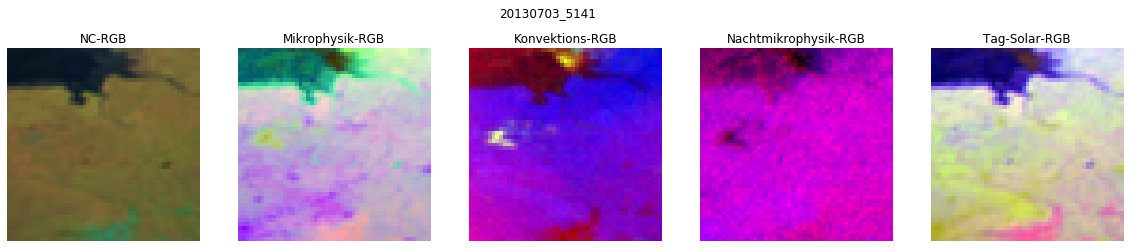

In [60]:
fig,ax = plt.subplots(1,5,figsize=(20,4))
ax[0].imshow(nc)
ax[0].axis("off")
ax[0].set_title("NC-RGB")
ax[1].imshow(mp)
ax[1].axis("off")
ax[1].set_title("Mikrophysik-RGB")
ax[2].imshow(cv)
ax[2].axis("off")
ax[2].set_title("Konvektions-RGB")
ax[3].imshow(ncv)
ax[3].axis("off")
ax[3].set_title("Nachtmikrophysik-RGB")
ax[4].imshow(ds)
ax[4].axis("off")
ax[4].set_title("Tag-Solar-RGB")
plt.suptitle(case_id)

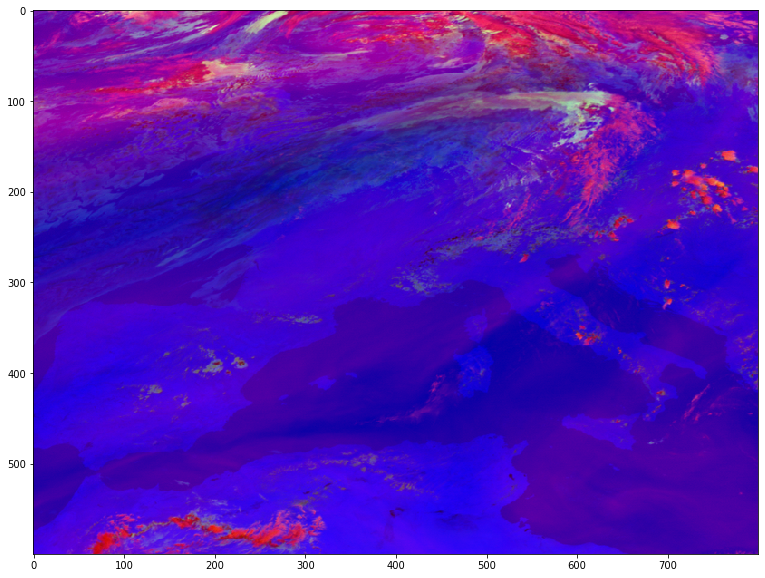

In [63]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(conv_rgb(sat_data['VIS006'],
                   sat_data['IR_016'],
                   sat_data['IR_039'],
                   sat_data['WV_062'],
                   sat_data['WV_073'],
                   sat_data['IR_108']))

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(day_micro(sat_data['VIS006'],
                   sat_data['IR_016'],
                   sat_data['IR_039'],
                   sat_data['WV_062'],
                   sat_data['WV_073'],
                   sat_data['IR_108']))

Region suggests use of hdf file


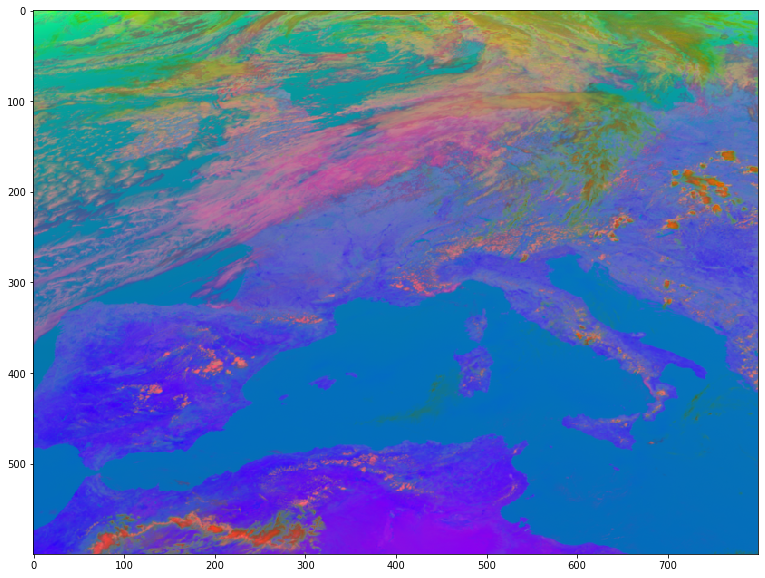

In [64]:
bt039, ref039 = determine_IR039_reflectance(ci_time)
fig,ax = plt.subplots(1,1,figsize=(16,10))

ax.imshow(day_microphysics_rgb(sat_data['VIS008'],ref039,sat_data['IR_108']))

In [631]:
from skimage import color
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [632]:
cv_rgb = conv_rgb(sat_data['VIS006'],
                  sat_data['IR_016'],
                  sat_data['IR_039'],
                  sat_data['WV_062'],
                  sat_data['WV_073'],
                  sat_data['IR_108'])

cv_lab = color.rgb2lab(cv_rgb)

In [633]:
mp_rgb = day_microphysics_rgb(sat_data['VIS008'],
                              ref_039,
                              sat_data['IR_108'])

mp_lab = color.rgb2lab(mp_rgb)

In [634]:
BuYl = LinearSegmentedColormap.from_list('BuYl', [[0,0,1,1],
                                                  [0.25,0.25,0.75,1],
                                                  [0.5,0.5,0.5,1],
                                                  [0.75,0.75,0.25,1],
                                                  [1,1,0,1]])

GnRd = LinearSegmentedColormap.from_list('GnRd', [[0,1,0,1],
                                                  [0.25,0.75,0,1],
                                                  [0.5,0.5,0,1],
                                                  [0.75,0.25,0,1],
                                                  [1,0,0,1]])

Text(0.5, 1.0, 'b')

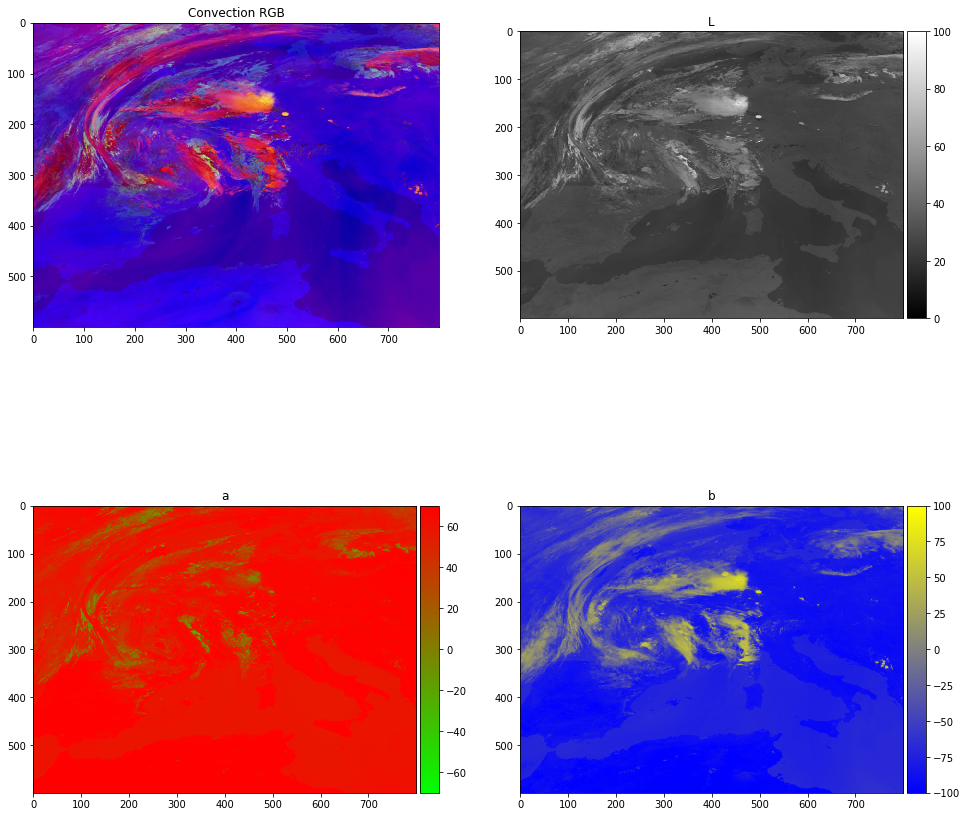

In [695]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
axs= ax.ravel()
axs[0].imshow(cv_rgb)
axs[0].set_title("Convection RGB")
l_plot = axs[1].imshow(cv_lab[:,:,0],vmin=0,vmax=100,cmap='gray')
axs[1].set_title("L")
fc.colourbar(l_plot)
a_plot = axs[2].imshow(cv_lab[:,:,1],vmin=-70,vmax=70,cmap=GnRd)
fc.colourbar(a_plot)
axs[2].set_title("a")
b_plot = axs[3].imshow(cv_lab[:,:,2],vmin=-100,vmax=100,cmap=BuYl)
fc.colourbar(b_plot)
axs[3].set_title("b")

Text(0.5, 1.0, 'b')

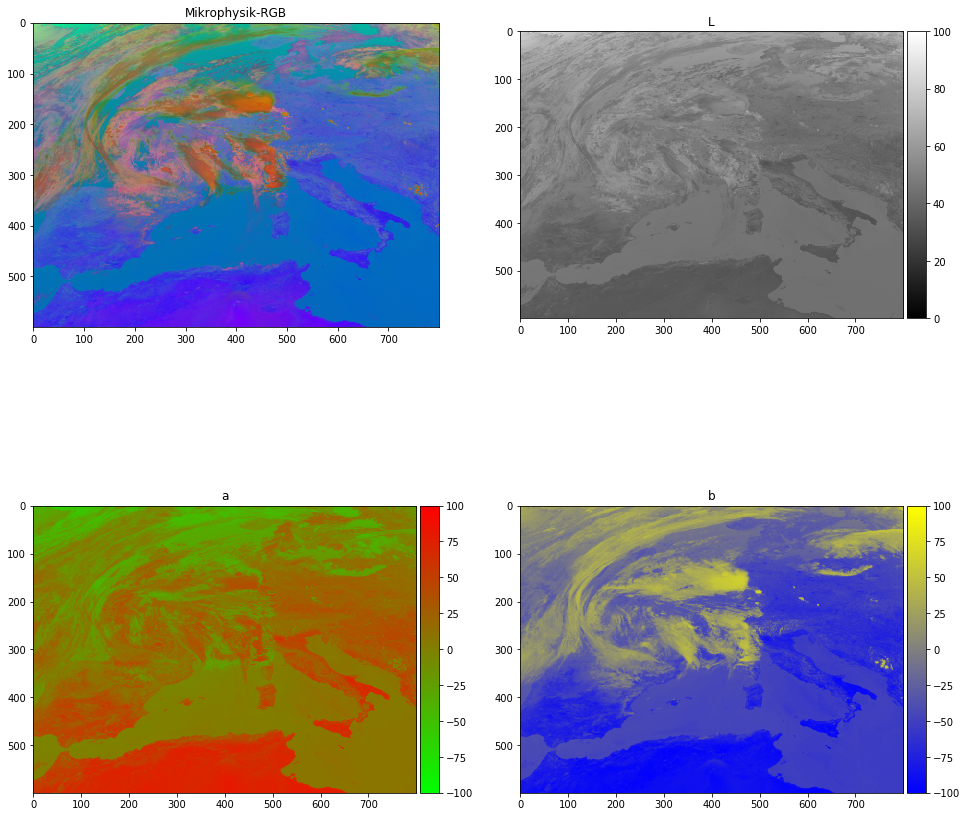

In [646]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
axs = ax.ravel()
axs[0].imshow(mp_rgb)
axs[0].set_title("Mikrophysik-RGB")
l_plot = axs[1].imshow(mp_lab[:,:,0],vmin=0,vmax=100,cmap='gray')
axs[1].set_title("L")
fc.colourbar(l_plot)
a_plot = axs[2].imshow(mp_lab[:,:,1],vmin=-100,vmax=100,cmap=GnRd)
fc.colourbar(a_plot)
axs[2].set_title("a")
b_plot = axs[3].imshow(mp_lab[:,:,2],vmin=-100,vmax=100,cmap=BuYl)
fc.colourbar(b_plot)
axs[3].set_title("b")